# Notebook #3: Queries, Visualización y Análisis

- En este tercer notebook realizaremos consultas sobre nuestra base de datos y las usaremos para generar visualizaciones y el análisis de las mismas.

- Las visualizaciones de Ploty no se renderizan en Github. Para poder verlas es necesaria la descarga del Notebook.

- A lo largo el notebook, los números con el formato "(1)" representan fuentes externas de información utilizadas, que se referencian al final de este notebook.

- El primer paso será importar las librerías necesarias:

In [1]:
# Librerías para tratamiento de datos
import pandas as pd
pd.set_option("display.max_columns", None) # Parámetro que modifica la visualización de los resultado3s
import numpy as np

# Trabajar con bases de datos SQL
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors

# Librería para el acceso a variables y funciones
import sys
sys.path.append("../")
from src import soporte_funciones as sf #Archivo .py donde encontraremos todas nuestras funciones.

# Librería de mapas
import folium

# Librerías para graficar
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# Librería para ignorar avisos
import warnings
warnings.filterwarnings("ignore") # Ignora TODOS los avisos

/Users/davidfranco/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Objeto del Análisis 

- Antes de plantearnos las queries que pretendemos realizar, debemos recordar que el objetivo del proyecto es obtener insights sobre el mercado, así como la estructura de los datos.

- La información con la que contamos tiene relación con el mercado de la vivienda en Madrid, e incluye:
    - Datos de viviendas turísticas (AirBnB).
    - Datos de viviendas de alquiler (Idelista y Redpiso).
    - Datos sobre los ingresos por hogar (INE).
    - Datos sobre cantidad de población nacional y extranjera (Ayuntamiento de Madrid).

#### Diagrama Entidad Relación

<img src="../images/DiagramaER.png" width="400">

- Para ejecutar nuestras queries, haremos uso de la función `sf.dbeaver_fetch()`, que recibe como argumentos la conexión a DBeaver (usamos la función `sf.dbeaver_conexion()`) y la query.

### 1. Precio Promedio del Alquiler por Distrito

In [19]:
query1= '''
SELECT d.nombre, 
    round(AVG(i.precio),2) AS avg_precio_idealista, 
    round(AVG(r.precio),2) AS avg_precio_redpiso,
    round(AVG(i.precio)+AVG(r.precio)/2,2) AS alquiler_prom
FROM distritos d
INNER JOIN idealista i ON d.id_distrito = i.id_distrito
INNER JOIN redpiso r ON d.id_distrito = r.id_distrito
INNER JOIN airbnb a ON d.id_distrito = a.id_distrito
GROUP BY d.nombre
ORDER BY alquiler_prom DESC
;'''

In [20]:
resultado1 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query1)
resultado1

,nombre,avg_precio_idealista,avg_precio_redpiso,alquiler_prom
0,Retiro,2076.94,2027.65,3090.77
1,Salamanca,2362.96,1377.27,3051.60
2,Centro,2268.11,1088.95,2812.58
3,Chamberi,2085.52,1367.30,2769.17
4,Chamartin,1944.84,1211.45,2550.56
5,Moncloa-Aravaca,1850.08,1225.00,2462.58
6,Fuencarral-El Pardo,1788.85,1133.40,2355.55
7,Arganzuela,1734.50,1121.43,2295.21
8,Hortaleza,1703.57,1167.68,2287.41
9,Tetuan,1610.68,1161.00,2191.18


In [77]:
fig1 = px.bar(resultado1, x='nombre', y='alquiler_prom', 
             title='Precio Promedio de Alquiler por Distrito al 1 de Nov. de 2024',
             labels={'nombre': 'Distrito', 'alquiler_prom': 'Precio Promedio de Alquiler (€)'},
             color='nombre')
             #color_discrete_sequence=px.colors.sequential.Viridis)

fig1.update_traces(marker_color='skyblue', text=resultado1['alquiler_prom'], texttemplate='%{y:.2f}', textposition='outside')

fig1.show()

### 2. Porcentaje del Ingreso del Hogar dedicado al Alquiler

In [4]:
query2='''
SELECT d.nombre, 
    round(AVG(i.precio)+AVG(r.precio)/2,2) AS alquiler_prom, 
    AVG(ih.total)/12 AS ingreso_prom_hogar,
    (AVG(i.precio)+AVG(r.precio)/2) / (AVG(ih.total)/12) AS porc_alquiler_ingreso
FROM distritos d
INNER JOIN idealista i ON d.id_distrito = i.id_distrito
INNER JOIN redpiso r ON d.id_distrito = r.id_distrito
INNER JOIN ingresos_hogar ih ON d.id_distrito = ih.id_distrito
GROUP BY d.nombre
ORDER BY porc_alquiler_ingreso DESC
;'''


In [5]:
resultado2 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query2)
resultado2

,nombre,alquiler_prom,ingreso_prom_hogar,porc_alquiler_ingreso
0,Centro,2812.58,2999.677083,0.937629
1,Tetuan,2191.18,3172.885417,0.690596
2,Usera,1621.43,2349.500000,0.690116
3,Puente de Vallecas,1524.30,2256.322917,0.675569
4,Latina,1800.28,2698.114583,0.667237
5,Retiro,3090.77,4637.322917,0.666498
6,Vicalvaro,1903.33,2895.270833,0.657394
7,Moratalaz,1982.50,3090.291667,0.641525
8,Ciudad Lineal,2082.83,3310.718750,0.629118
9,Arganzuela,2295.21,3684.468750,0.622943


In [44]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x=resultado2['nombre'], y=resultado2['alquiler_prom'],
                         mode='lines+markers',
                         name='Precio Promedio de Alquiler'))
                         
fig2.add_trace(go.Scatter(x=resultado2['nombre'], y=resultado2['ingreso_prom_hogar'],
                         mode='lines+markers',
                         name='Ingreso Promedio por Hogar'))

fig2.update_layout(title='Precio Promedio de Alquiler vs. Ingreso Promedio por Hogar',
                  xaxis_title='Distrito',
                  yaxis_title='Euros',
                  xaxis_tickangle=-45)

fig2.show()

### 3. Identificación de outliers en precios de Idealista y Redpiso

In [6]:
query3 = '''
SELECT 
    'Idealista' AS fuente,
    precio 
FROM 
    idealista
UNION ALL
SELECT 
    'Redpiso' AS fuente,
    precio 
FROM 
    redpiso
;'''

In [7]:
resultado3 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query3)
resultado3

,fuente,precio
0,Idealista,1350
1,Idealista,2300
2,Idealista,1200
3,Idealista,3200
4,Idealista,750
...,...,...
920,Redpiso,1500
921,Redpiso,1500
922,Redpiso,1500
923,Redpiso,1500


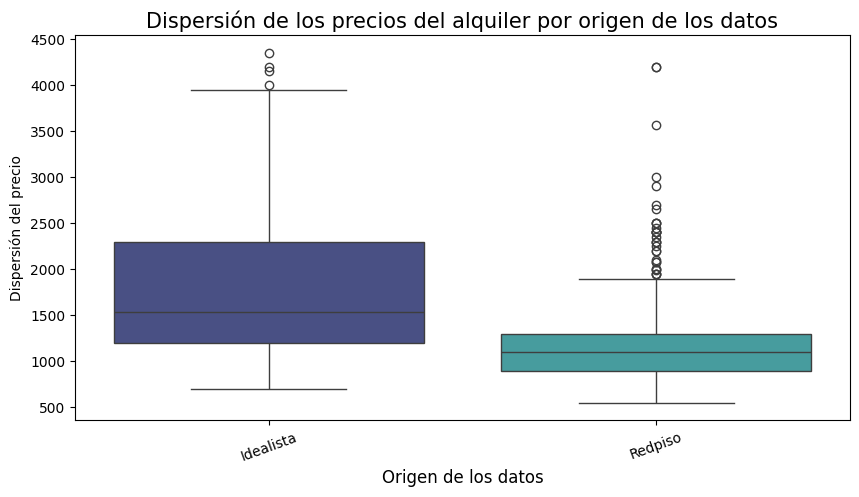

In [8]:
plt.figure(figsize = (10,5))
sns.boxplot(x = "fuente",
            y = "precio",
            data = resultado3, 
            palette = "mako",
            )


plt.xticks(rotation = 20)
plt.title("Dispersión de los precios del alquiler por origen de los datos", fontsize = 15)
plt.xlabel("Origen de los datos", fontsize = 12)
plt.ylabel("Dispersión del precio")

plt.show()

### 4. Conteo de Anuncios de Alquiler por Distrito

In [9]:
query4 = '''
SELECT d.nombre, 
       (SELECT COUNT(*)
            FROM idealista i
            WHERE i.id_distrito = d.id_distrito) AS idealista, 
       (SELECT COUNT(*)
            FROM redpiso r
            WHERE r.id_distrito = d.id_distrito) AS redpiso, 
       (SELECT COUNT(*)
            FROM airbnb a
            WHERE a.id_distrito = d.id_distrito) AS airbnb
FROM distritos d;
;'''

In [10]:
resultado4 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query4)
resultado4

,nombre,idealista,redpiso,airbnb
0,Centro,74,62,210
1,Arganzuela,20,35,29
2,Retiro,18,17,8
3,Salamanca,27,33,13
4,Chamartin,31,69,4
5,Tetuan,22,25,22
6,Chamberi,29,74,26
7,Fuencarral-El Pardo,13,47,1
8,Moncloa-Aravaca,26,26,6
9,Latina,16,31,3


In [51]:
fig4 = go.Figure()

fig4.add_trace(go.Scatter(x=resultado4['nombre'], y=resultado4['idealista'],
                         mode='lines+markers',
                         name='Idealista'))

fig4.add_trace(go.Scatter(x=resultado4['nombre'], y=resultado4['redpiso'],
                         mode='lines+markers',
                         name='Redpiso'))

fig4.add_trace(go.Scatter(x=resultado4['nombre'], y=resultado4['airbnb'],
                         mode='lines+markers',
                         name='Airbnb'))

fig4.update_layout(title='Cantidad de Anuncios por Fuente y Distrito',
                  xaxis_title='Distrito',
                  yaxis_title='Cantidad de Anuncios',
                  xaxis_tickangle=-45)

fig4.show()


### 5. Cambio de la población en el período del 2018 al 2022

In [11]:
query5='''
SELECT d.nombre, 
       SUM(p.espanioles) AS total_espanoles, 
       SUM(p.extranjeros) AS total_extranjeros, 
       SUM(p.total) AS total_cambio
FROM distritos d
INNER JOIN poblacion p ON d.id_distrito = p.id_distrito
GROUP BY d.nombre
ORDER BY total_cambio DESC
;'''

In [12]:
resultado5 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query5)
resultado5

,nombre,total_espanoles,total_extranjeros,total_cambio
0,Hortaleza,6955,5965,12918
1,Carabanchel,-2868,14443,11574
2,Villaverde,1811,9439,11246
3,Villa de Vallecas,5306,5231,10543
4,Vicalvaro,6419,2820,9239
5,Puente de Vallecas,-5441,13529,8087
6,Centro,-1425,9189,7761
7,Fuencarral-El Pardo,3201,4434,7634
8,Usera,-1834,7862,6031
9,San Blas,-2606,7116,4509


In [54]:
fig5 = go.Figure()

fig5.add_trace(go.Scatter(x=resultado5['nombre'], y=resultado5['total_espanoles'],
                         mode='lines+markers',
                         name='Total Españoles'))

fig5.add_trace(go.Scatter(x=resultado5['nombre'], y=resultado5['total_extranjeros'],
                         mode='lines+markers',
                         name='Total Extranjeros'))

fig5.update_layout(title='Variación de Habitantes por Distrito entre el 2018 y el 2022 (Españoles vs. Extranjeros)',
                  xaxis_title='Distrito',
                  yaxis_title='Cantidad de Personas',
                  xaxis_tickangle=-45)

fig5.show()

### 6. Relación entre nacionalidad en el año 2022 y AirBnBs por distrito

In [13]:
query6 = '''
SELECT 
    d.nombre AS distrito, 
    (AVG(i.precio) + AVG(r.precio)) / 2 AS precio_medio_alquiler, 
    p.espanioles,
    p.extranjeros,
    ab.cantidad_airbnbs
FROM 
    distritos d
INNER JOIN 
    idealista i ON d.id_distrito = i.id_distrito
INNER JOIN 
    redpiso r ON d.id_distrito = r.id_distrito
INNER JOIN 
    poblacion p ON d.id_distrito = p.id_distrito
INNER JOIN
    (SELECT id_distrito, COUNT(*) AS cantidad_airbnbs 
     FROM airbnb 
     GROUP BY id_distrito) ab ON d.id_distrito = ab.id_distrito
WHERE
    p.periodo = 2022
GROUP BY 
    d.nombre, p.espanioles, p.extranjeros, ab.cantidad_airbnbs
ORDER BY
    p.extranjeros DESC
;'''

In [14]:
resultado6 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query6)
resultado6

,distrito,precio_medio_alquiler,espanioles,extranjeros,cantidad_airbnbs
0,Salamanca,1870.1178451178451179,-868,622,13
1,Centro,1678.5298605056669573,-1947,519,210
2,Hortaleza,1435.6266233766233766,241,332,5
3,Chamberi,1726.4072693383038211,-1071,146,26
4,Retiro,2052.2957516339869281,-713,96,8
5,San Blas,1202.1818181818181818,-922,-77,4
6,Barajas,982.5000000000000000,214,-84,4
7,Chamartin,1578.1439925198690977,-938,-247,4
8,Arganzuela,1427.9642857142857143,-930,-338,29
9,Moncloa-Aravaca,1537.5384615384615385,94,-351,6


In [71]:
resultado6 = resultado6.sort_values(by='precio_medio_alquiler', ascending=False)

fig6 = go.Figure()

fig6.add_trace(go.Bar(x=resultado6['distrito'], y=resultado6['precio_medio_alquiler'],
                      name='Precio Medio Alquiler'))
fig6.update_traces(marker_color='lightblue')

fig6.add_trace(go.Scatter(x=resultado6['distrito'], y=resultado6['espanioles'],
                          mode='lines+markers',
                          name='Españoles'))

fig6.add_trace(go.Scatter(x=resultado6['distrito'], y=resultado6['extranjeros'],
                          mode='lines+markers',
                          name='Extranjeros'))

fig6.add_trace(go.Scatter(x=resultado6['distrito'], y=resultado6['cantidad_airbnbs'],
                          mode='lines+markers',
                          name='Cantidad de Airbnbs'))

fig6.update_layout(title='Análisis por Distrito',
                   xaxis_title='Distrito',
                   yaxis_title='Valores',
                   xaxis_tickangle=-45,
                   barmode='group')  # Agrupa las barras


fig6.show()

### 7. Precio medio de 2 noches de AirBnB
- Fechas consultadas: 31 de enero al 2 de febrero de 2025 para 2 adultos.

In [57]:
query7='''
SELECT 
    round(AVG(precio),2) AS precio_promedio_airbnb
FROM 
    airbnb;
'''

In [58]:
resultado7 = sf.dbeaver_fetch(sf.dbeaver_conexion("alquileresmadrid"),query7)
resultado7

,precio_promedio_airbnb
0,243.21


## Mapa